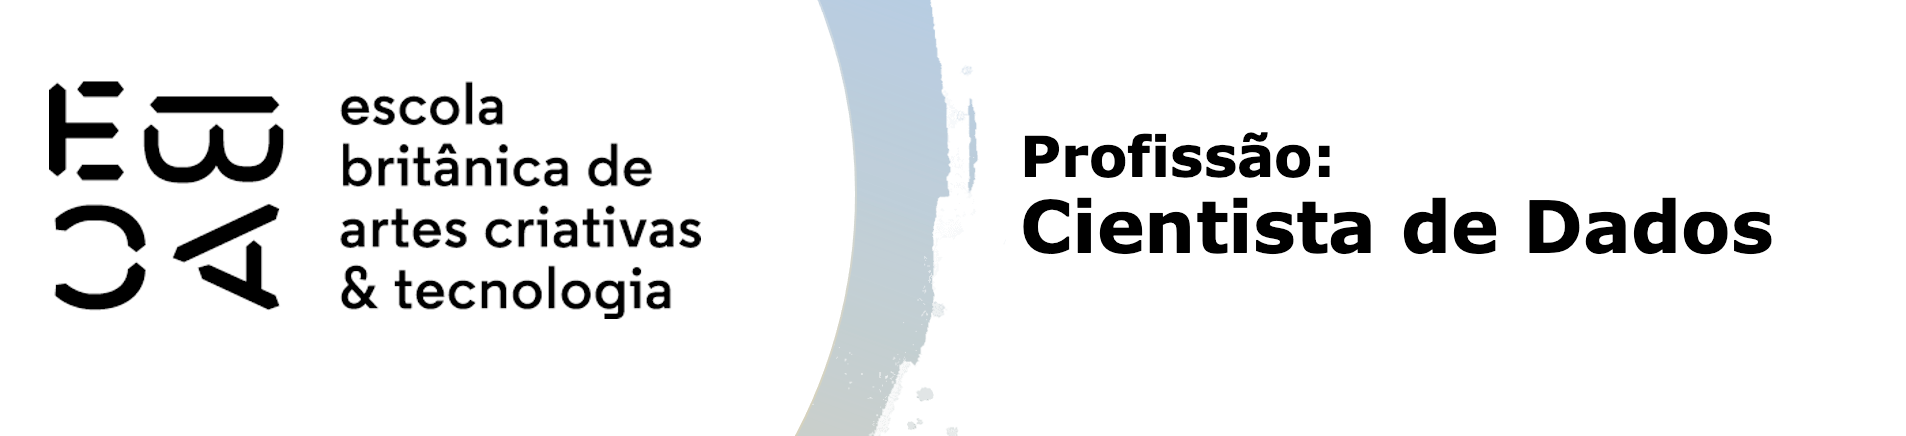

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

import warnings;   warnings.filterwarnings("ignore")

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
df_original = pd.read_feather('./data/credit_scoring.ftr')
df = df_original.copy()
print(df.shape)
print(df.info())
df.head()

(750000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 n

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
#Criando as bases de treino e teste tirando colunas que não são interessantes e seprando em safras
print(df.data_ref.unique())
df_train = df[(df['data_ref'] >= '2015-01-01') & (df['data_ref'] <= '2015-12-01')]
print(df_train.shape)
df_train .head(2)

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]
(600000, 15)


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False


In [4]:
#Separando os ultimos 3 meses
df_test  = df[df['data_ref'] >= '2016-01-01']
print(df_test .shape)
df_test .head(2)

(150000, 15)


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
print(f'Números de linhas: {df.shape[0]}\n')
print('Número de linhas por mês:')
df.data_ref.value_counts()

Números de linhas: 750000

Número de linhas por mês:


data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [6]:
# Descritiva básica univariada de cada variável
df1 = df.copy()
df1.drop(columns=['index', 'data_ref'], inplace = True)
for coluna in df1:
    print(df[coluna].value_counts())
    print(df[coluna].describe())
    print('\n')

sexo
F    504580
M    245420
Name: count, dtype: int64
count     750000
unique         2
top            F
freq      504580
Name: sexo, dtype: object


posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64
count     750000
unique         2
top            N
freq      457954
Name: posse_de_veiculo, dtype: object


posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64
count     750000
unique         2
top            S
freq      503692
Name: posse_de_imovel, dtype: object


qtd_filhos
0     517331
1     153021
2      69632
3       8669
4       1065
7        101
5         95
14        86
Name: count, dtype: int64
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64


tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista              

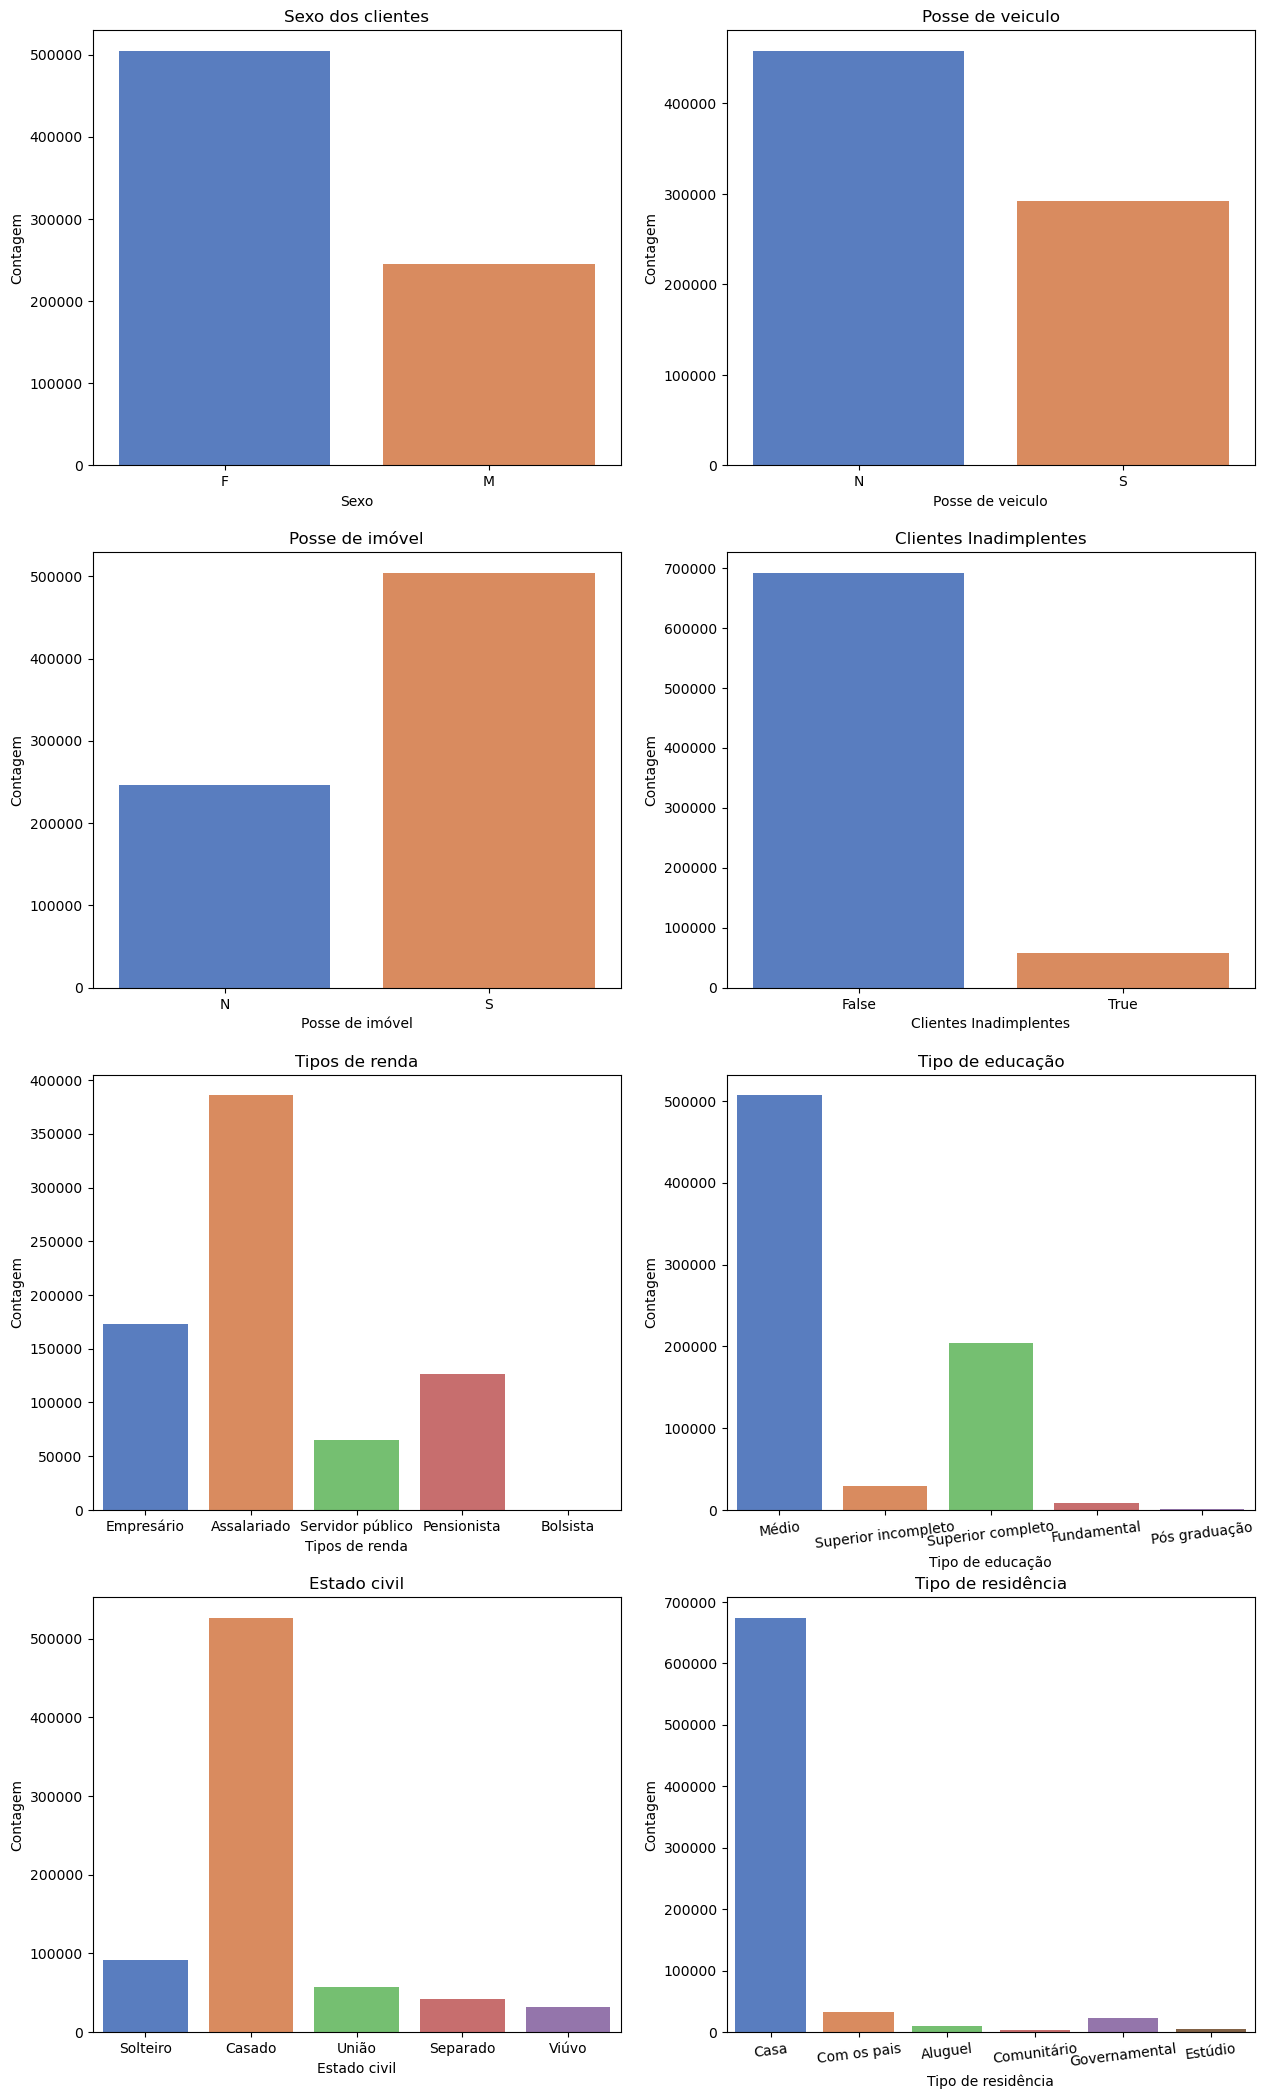

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df1, x='sexo', palette='muted', ax=ax[0,0])
ax[0,0].set_title('Sexo dos clientes')
ax[0,0].set_xlabel('Sexo')
ax[0,0].set_ylabel('Contagem')

sns.countplot(data=df1, x='posse_de_veiculo', palette='muted', ax=ax[0,1])
ax[0,1].set_title('Posse de veiculo')
ax[0,1].set_xlabel('Posse de veiculo')
ax[0,1].set_ylabel('Contagem')

sns.countplot(data=df1, x='posse_de_imovel', palette='muted', ax=ax[1,0])
ax[1,0].set_title('Posse de imóvel')
ax[1,0].set_xlabel('Posse de imóvel')
ax[1,0].set_ylabel('Contagem')

sns.countplot(data=df1, x='mau', palette='muted', ax=ax[1,1])
ax[1,1].set_title('Clientes Inadimplentes')
ax[1,1].set_xlabel('Clientes Inadimplentes')
ax[1,1].set_ylabel('Contagem')

sns.countplot(data=df1, x='tipo_renda', palette='muted', ax=ax[2,0])
ax[2,0].set_title('Tipos de renda')
ax[2,0].set_xlabel('Tipos de renda')
ax[2,0].set_ylabel('Contagem')

sns.countplot(data=df1, x='educacao', palette='muted', ax=ax[2,1])
ax[2,1].set_title('Tipo de educação')
ax[2,1].set_xlabel('Tipo de educação')
ax[2,1].set_ylabel('Contagem')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df1, x='estado_civil',  palette='muted', ax=ax[3,0])
ax[3,0].set_title('Estado civil')
ax[3,0].set_xlabel('Estado civil')
ax[3,0].set_ylabel('Contagem')

sns.countplot(data=df1, x='tipo_residencia', palette='muted', ax=ax[3,1])
ax[3,1].set_title('Tipo de residência')
ax[3,1].set_xlabel('Tipo de residência')
ax[3,1].set_ylabel('Contagem')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)

<Axes: xlabel='idade', ylabel='count'>

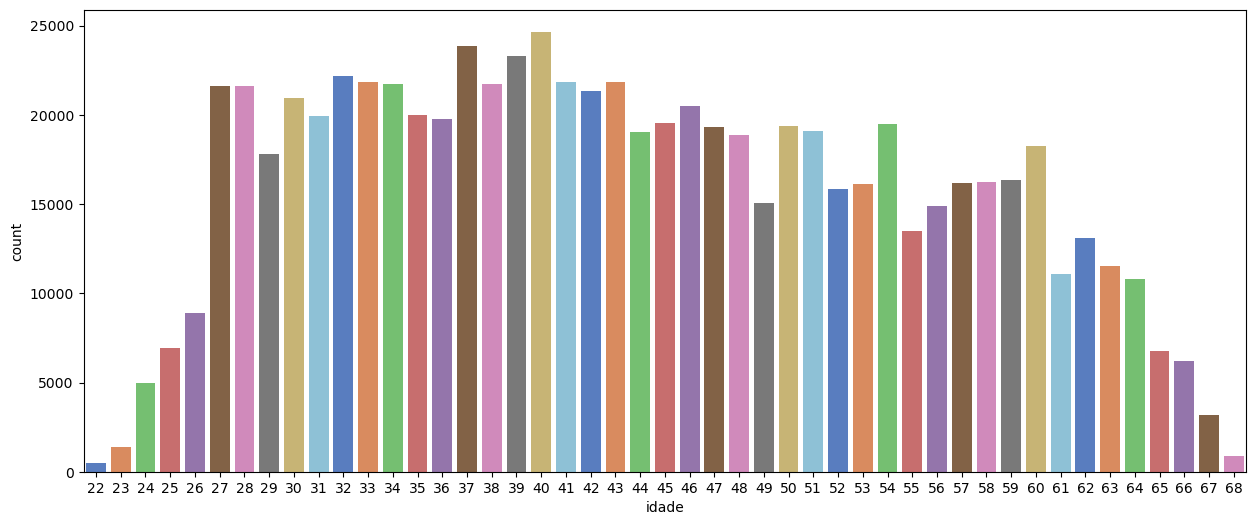

In [8]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df1, x='idade', palette='muted')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

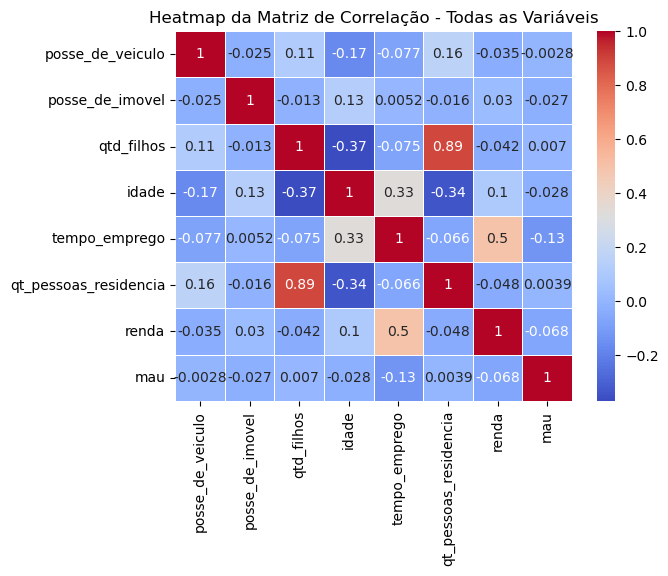

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
posse_de_veiculo,1.000000,-0.025386,0.113998,-0.169761,-0.076900,0.163130,-0.034648,-0.002793
posse_de_imovel,-0.025386,1.000000,-0.012533,0.131894,0.005223,-0.016094,0.029582,-0.026797
qtd_filhos,0.113998,-0.012533,1.000000,-0.370234,-0.075299,0.890352,-0.041886,0.007018
idade,-0.169761,0.131894,-0.370234,1.000000,0.330063,-0.341151,0.101772,-0.027989
tempo_emprego,-0.076900,0.005223,-0.075299,0.330063,1.000000,-0.066361,0.496360,-0.132118
qt_pessoas_residencia,0.163130,-0.016094,0.890352,-0.341151,-0.066361,1.000000,-0.047790,0.003878
renda,-0.034648,0.029582,-0.041886,0.101772,0.496360,-0.047790,1.000000,-0.067978
mau,-0.002793,-0.026797,0.007018,-0.027989,-0.132118,0.003878,-0.067978,1.000000


In [9]:
# Correlação com as variaveis qualitativas
df1['mau'] = df1['mau'].astype('int64')
df1['posse_de_veiculo'] = df1['posse_de_veiculo'].replace({'N': 0, 'S': 1})
df1['posse_de_imovel'] = df1['posse_de_imovel'].replace({'N': 0, 'S': 1})
df_num = df1.select_dtypes(include=['float64', 'int64'])
correlação = df_num.corr()

sns.heatmap(correlação, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap da Matriz de Correlação - Todas as Variáveis")
plt.show()
correlação

Text(0.5, 0, 'Datas')

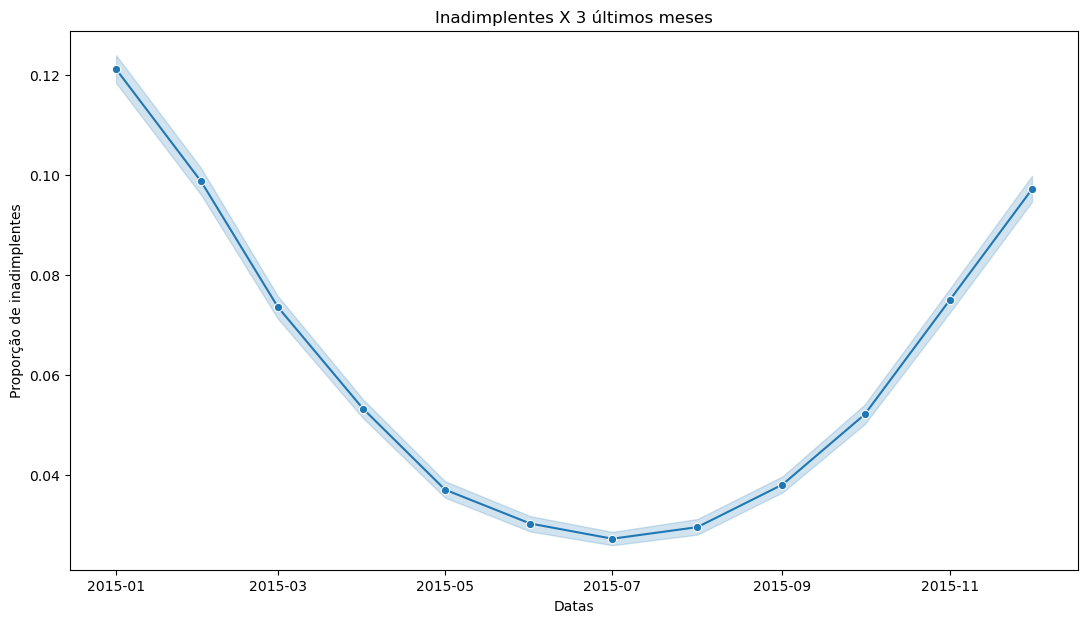

In [10]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df_train, x='data_ref', y='mau', palette='mako', ax=ax, marker='o')
ax.set_title('Inadimplentes X 3 últimos meses')
ax.set_ylabel('Proporção de inadimplentes')
ax.set_xlabel('Datas')

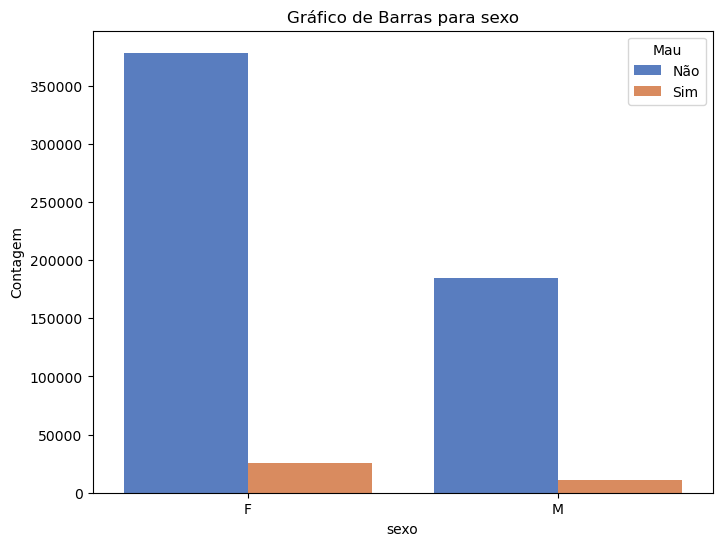

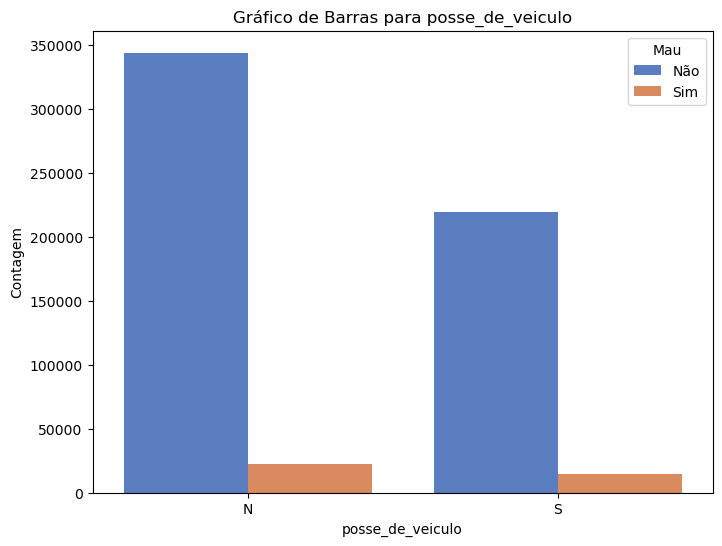

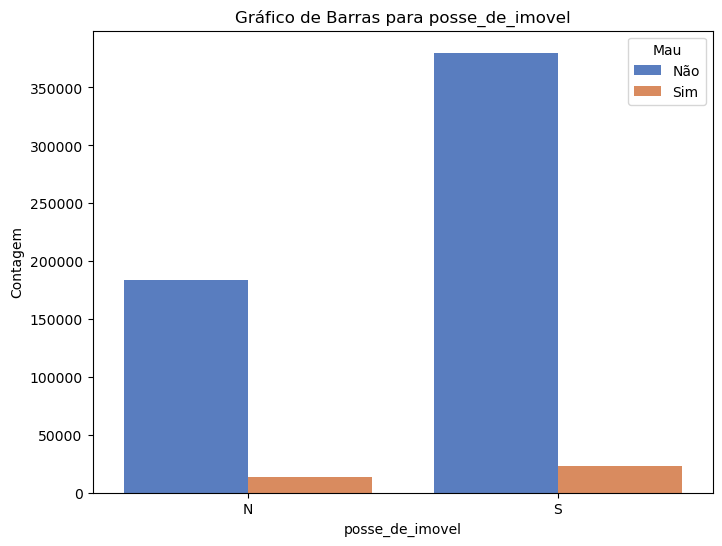

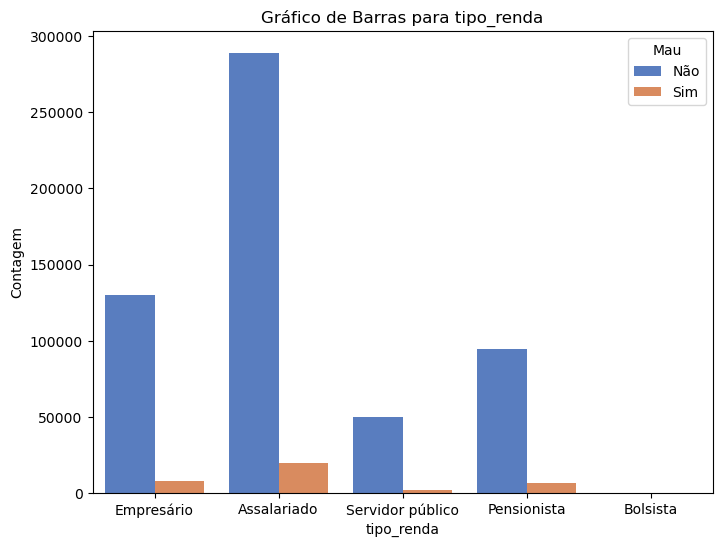

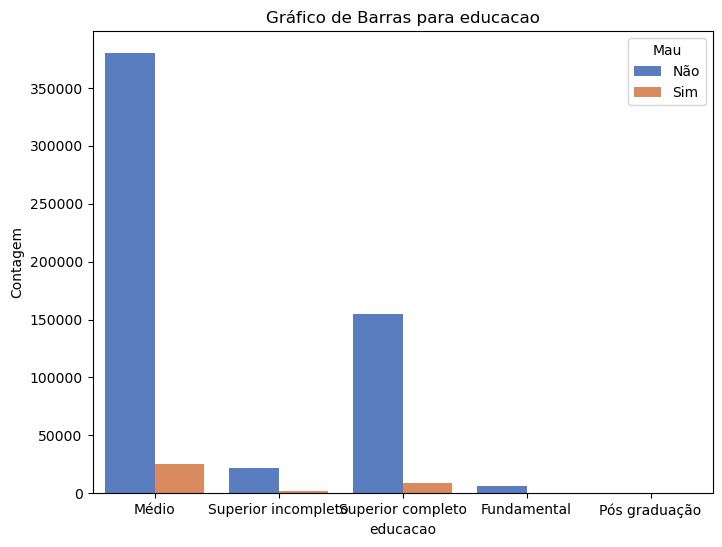

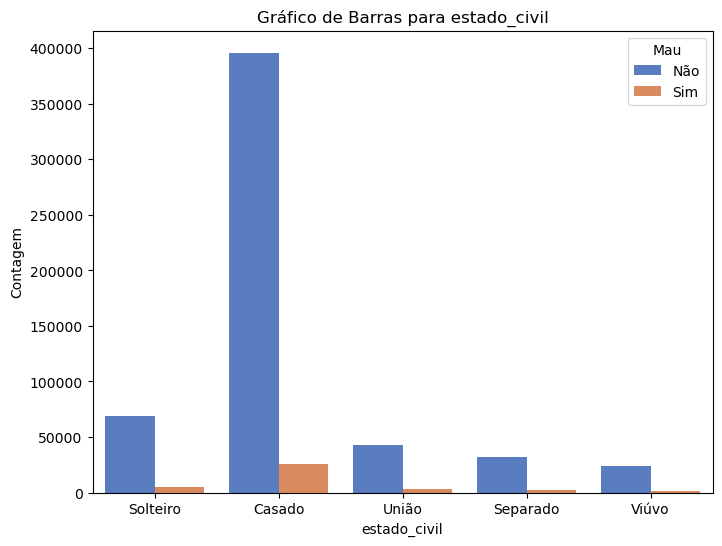

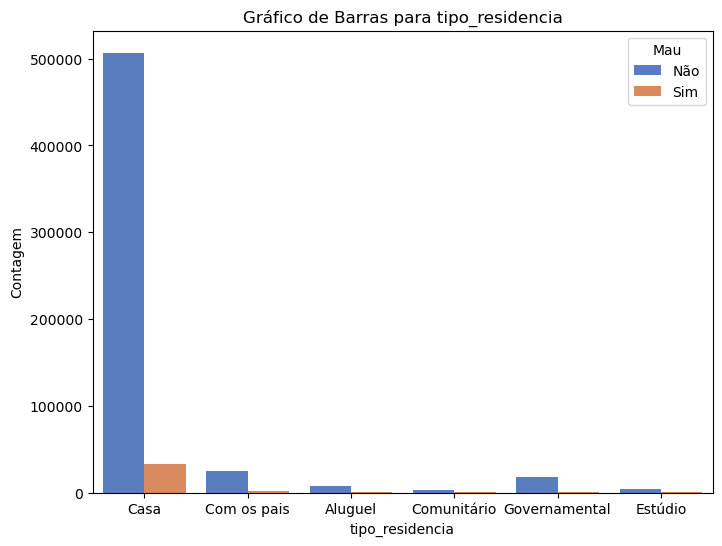

In [11]:
# Gráficos comparativos de variaveis qualitativas com inadimplentes
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 
                          'estado_civil', 'tipo_residencia']
for variavel in variaveis_qualitativas:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=variavel, hue='mau', data=df_train, palette='muted')
    plt.xlabel(variavel)
    plt.ylabel('Contagem')
    plt.title(f'Gráfico de Barras para {variavel}')
    plt.legend(title='Mau', labels=['Não', 'Sim'])
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [12]:
# Trato valores missings
missing_values = df1.isnull().sum()
missing_values

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [13]:
faltantes = missing_values.tempo_emprego
print(f'Como há cerca de {faltantes} dados faltantes, que correspondem a {faltantes/df1.shape[0]*100:.2f}%, iremos substituir pela média para evitar uma perda significativa de informações.')

Como há cerca de 125957 dados faltantes, que correspondem a 16.79%, iremos substituir pela média para evitar uma perda significativa de informações.


In [14]:
media_tempo_emprego = df1['tempo_emprego'].mean()
df1['tempo_emprego'] = df1['tempo_emprego'].fillna(media_tempo_emprego)
df1.isnull().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

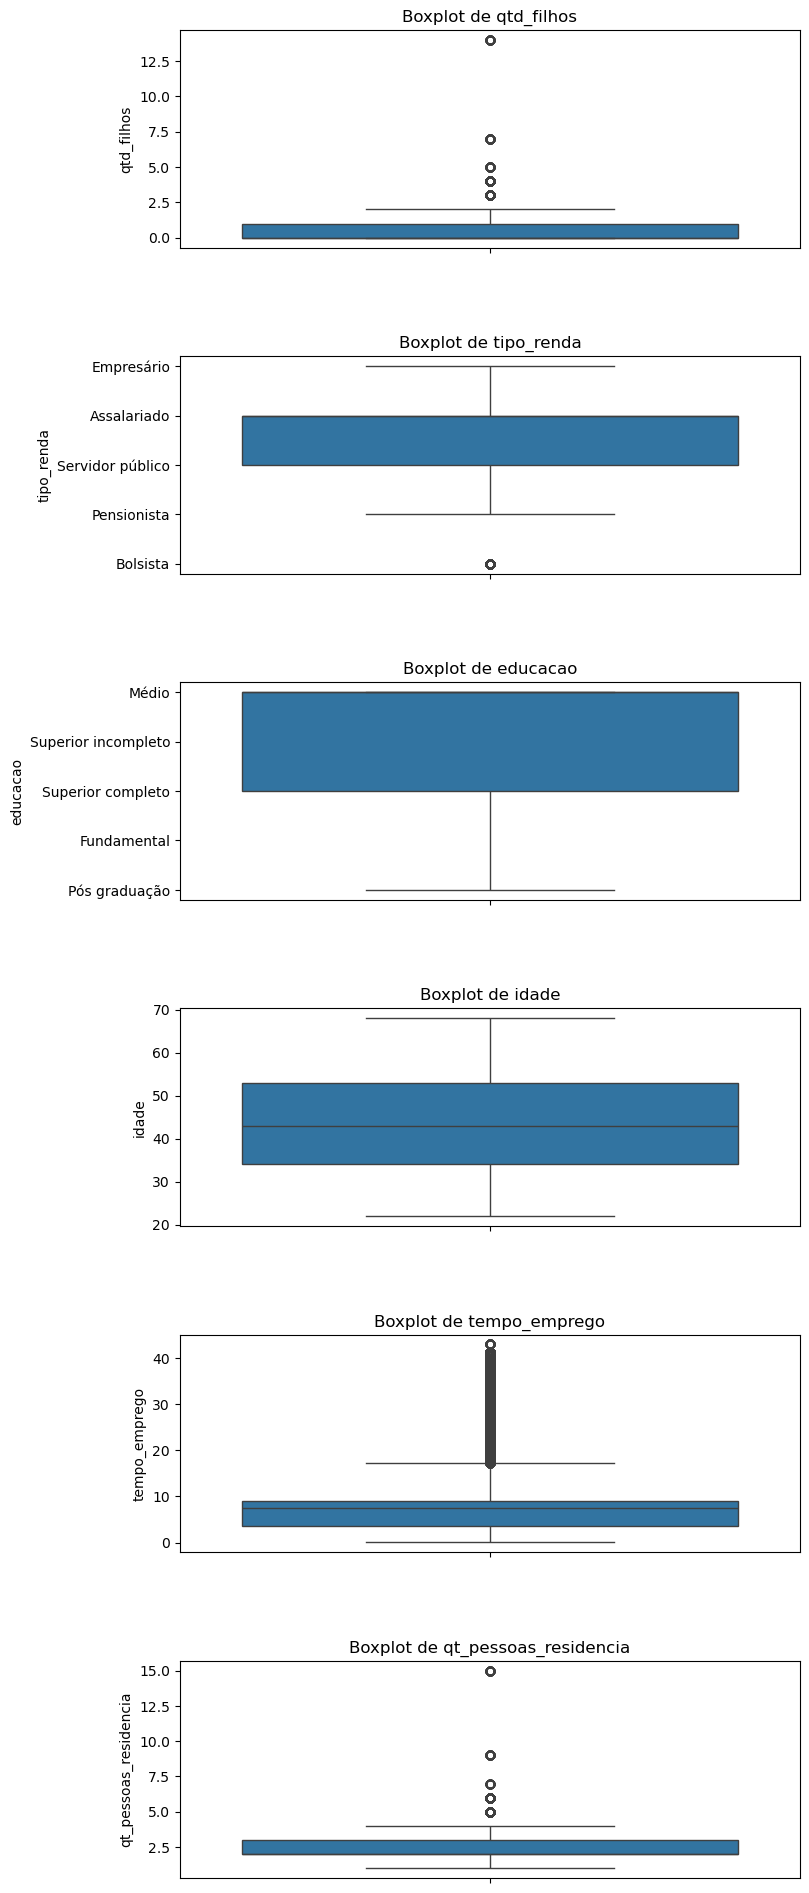

CPU times: total: 2.34 s
Wall time: 6.64 s


In [15]:
%%time
variaveis_independentes = ['qtd_filhos', 'tipo_renda', 'educacao', 
                           'idade', 'tempo_emprego', 'qt_pessoas_residencia']

fig, axes = plt.subplots(nrows=len(variaveis_independentes), ncols=1, figsize=(8, 4 * len(variaveis_independentes)))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, var in enumerate(variaveis_independentes):
    sns.boxplot(y=var, data=df1, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var}')

plt.show()

Analisando as variáveis, notamos que há alguns outliers, principalmente na variável 'tempo_emprego'. No exercício do Módulo 35, identificamos que esses casos podem ocorrer no mundo real e, por isso, eu não consideraria esses indivíduos como outliers.

In [16]:
#Vamos reajustar as bases 
df['mau'] = df['mau'].astype('int64')
df['posse_de_veiculo'] = df['posse_de_veiculo'].replace({'N': 0, 'S': 1})
df['posse_de_imovel'] = df['posse_de_imovel'].replace({'N': 0, 'S': 1})
df['sexo'] = df['sexo'].replace({'F': 0, 'M': 1})

media_tempo_emprego = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(media_tempo_emprego)


df_train = df[(df['data_ref'] >= '2015-01-01') & (df['data_ref'] <= '2015-12-01')]
df_train.drop(columns=['index', 'data_ref'], inplace = True)

print(df_train.shape)
print(df_train.info())
df_train.head(2)

(600000, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  int64  
 1   posse_de_veiculo       600000 non-null  int64  
 2   posse_de_imovel        600000 non-null  int64  
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 64.1+ MB
None


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,0,0,0,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,0,1,1,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0


In [17]:
    df_test  = df[df['data_ref'] >= '2016-01-01']
    df_test.drop(columns=['index', 'data_ref'], inplace = True)
print(df_test .shape)
df_test .head(2)

(150000, 13)


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,0,1,1,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,1
600001,0,0,1,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,0


In [18]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['unicos'] = df_train.nunique()

In [19]:
# Função IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# Populando o metadados
for var in metadados[metadados.papel == 'covariavel'].index:
    if pd.api.types.is_numeric_dtype(df_train[var]):
        if metadados.loc[var, 'unicos'] > 50:
            metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var], 5, duplicates='drop'), df_train.mau)
        else:
            metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

In [20]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Irrelevante'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] > 0.5, 'poder_preditivo'] = 'Atenção, muito alto'
metadados

,dtype,nmissing,papel,unicos,IV,poder_preditivo
sexo,int64,0,covariavel,2,0.002665,Irrelevante
posse_de_veiculo,int64,0,covariavel,2,0.000075,Irrelevante
posse_de_imovel,int64,0,covariavel,2,0.009690,Irrelevante
qtd_filhos,int64,0,covariavel,8,0.001689,Irrelevante
tipo_renda,object,0,covariavel,5,0.009718,Irrelevante
educacao,object,0,covariavel,5,0.003690,Irrelevante
estado_civil,object,0,covariavel,5,0.001305,Irrelevante
tipo_residencia,object,0,covariavel,6,0.003330,Irrelevante
idade,int64,0,covariavel,47,0.025662,Fraco
tempo_emprego,float64,0,covariavel,3005,0.283956,Médio


In [21]:
from IPython.display import display

def biv_discreta(var, df):
    df['bom'] = 1 - df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** .5
    biv['mau_sup'] = biv.mau + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau + t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    print(f"\nDistribuição de {var}:\n")
    display(df[var].value_counts())

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat - .7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    plt.subplots_adjust(hspace=0.5)

    ax[1] = biv.cont.plot.bar()
    
    display(biv)
    
    return biv

In [22]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    print(f"\nDistribuição de {var}:\n")
    display(df[var].value_counts())

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    
    display(biv)

    return None


Distribuição de qtd_filhos:



qtd_filhos
0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: count, dtype: int64

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


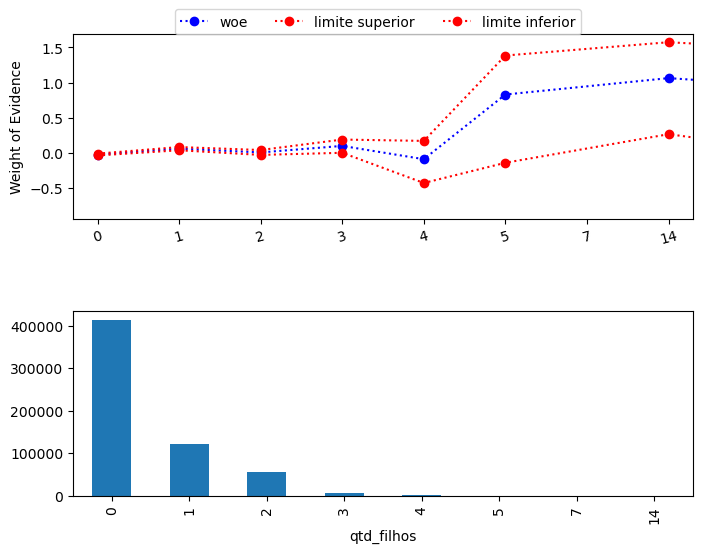

In [23]:
biv_discreta('qtd_filhos', df_train);


Distribuição de qtd_filhos:



qtd_filhos
0    413882
1    122471
2     55603
3      8044
Name: count, dtype: int64

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,7499,545,0.067752,3,8044,0.002802,0.073245,0.062259,-2.621739,-2.537875,-2.712164,0.110952,0.194816,0.020528


qtd_filhos
0    413882
1    122471
2     55603
3      8044
Name: count, dtype: int64


0.001313822229647469

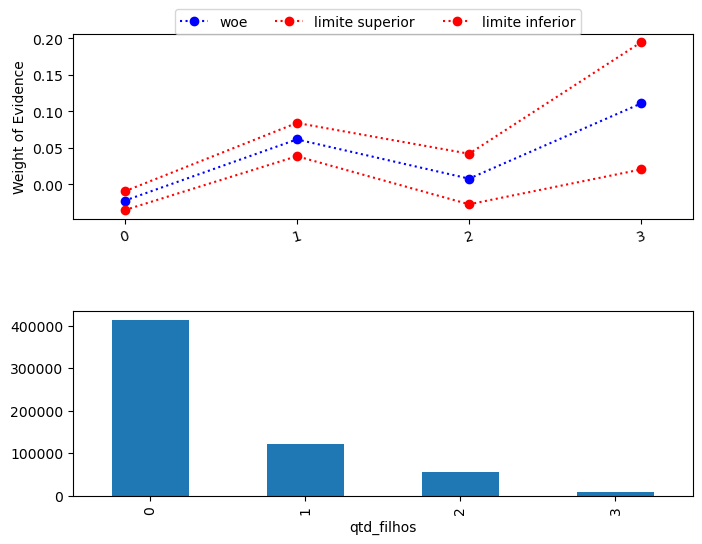

In [24]:
# Acredito que podemos melhorar juntando as classes da variável qtd_filhos
df_train.qtd_filhos.replace({4:3, 5:3, 7:3, 14:3}, inplace=True)

biv_discreta('qtd_filhos', df_train);
print(df_train.qtd_filhos.value_counts())
IV(df_train.qtd_filhos, df_train.mau)


Distribuição de estado_civil:



estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


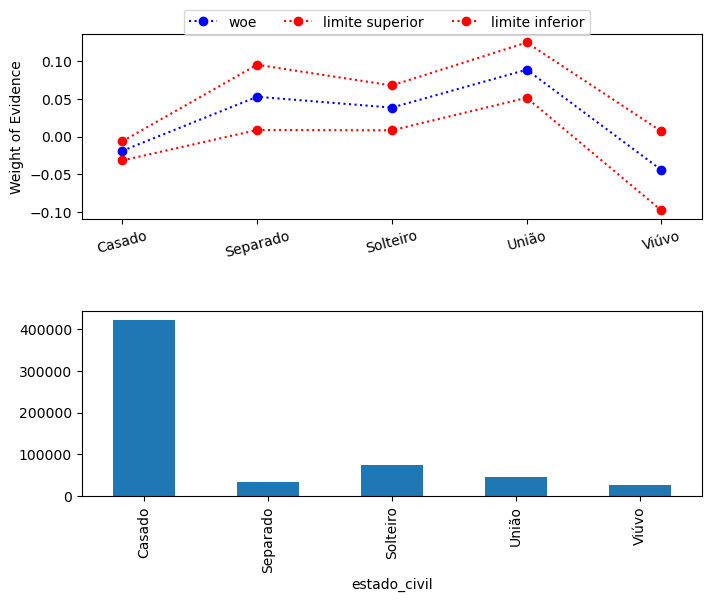

In [25]:
biv_discreta('estado_civil', df_train);


Distribuição de tipo_residencia:



tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


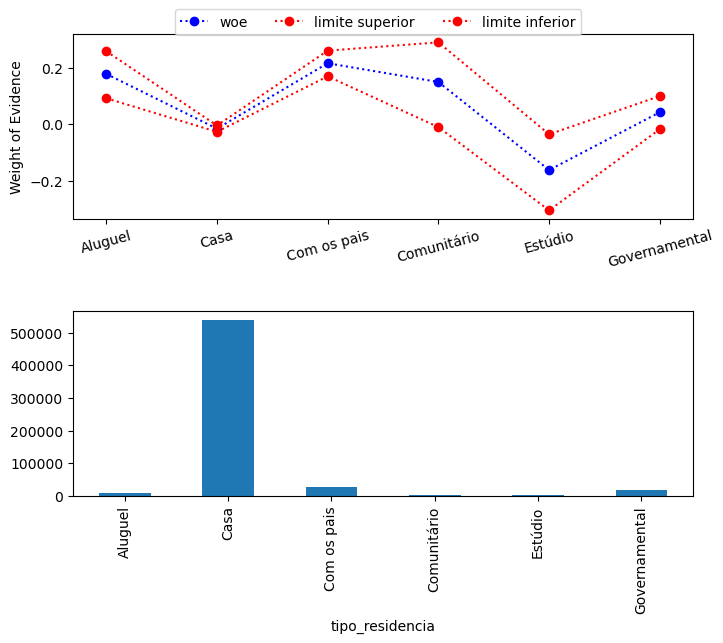

In [26]:
biv_discreta('tipo_residencia', df_train);


Distribuição de qt_pessoas_residencia:



qt_pessoas_residencia
2.0     326181
1.0     108657
3.0     104126
4.0      53314
5.0       6638
6.0        890
9.0         82
15.0        71
7.0         41
Name: count, dtype: int64

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",408788,26050,0.059907,1.750121,434838,0.000360,0.060613,0.059202,-2.753179,-2.740723,-2.765773,-0.020488,-0.008032,-0.033082
"(2.0, 3.0]",97323,6803,0.065334,3.000000,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
"(3.0, 4.0]",50051,3263,0.061203,4.000000,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
"(4.0, 15.0]",7195,527,0.068247,5.260295,7722,0.002870,0.073872,0.062621,-2.613941,-2.528681,-2.705982,0.118750,0.204010,0.026709


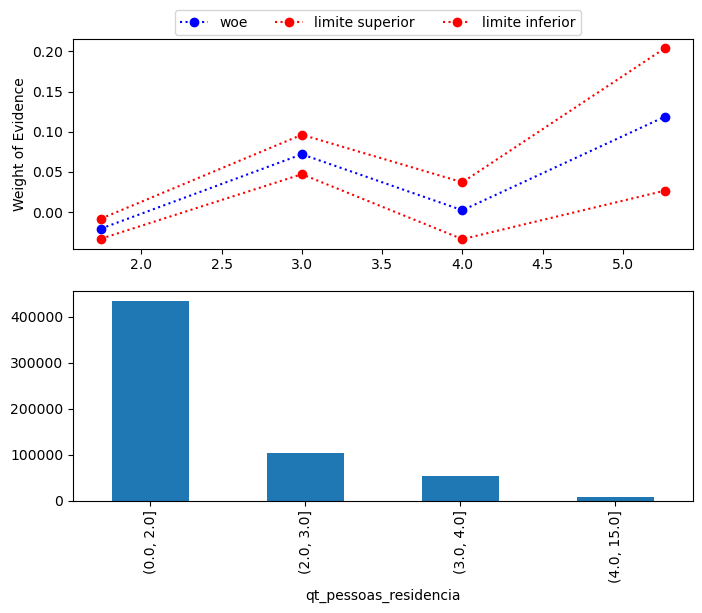

In [27]:
biv_continua('qt_pessoas_residencia', 10, df_train);


Distribuição de educacao:



educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


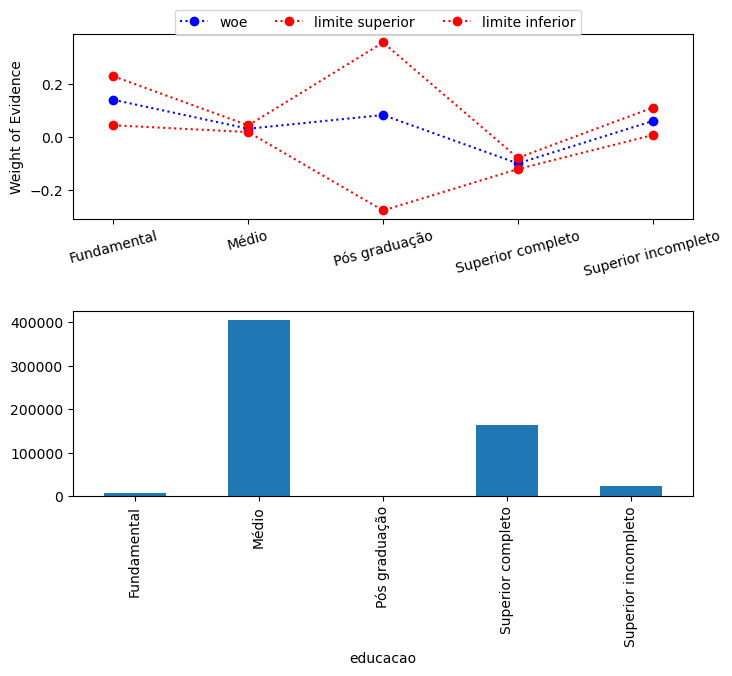

In [28]:
biv_discreta('educacao', df_train);


Distribuição de educacao:



educacao
Fundamental/Médio                    412350
Superior_Completo_e_Pós_graduação    164091
Superior incompleto                   23559
Name: count, dtype: int64

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,386359,25991,0.063031,Fundamental/Médio,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550
Superior_Completo_e_Pós_graduação,154962,9129,0.055634,Superior_Completo_e_Pós_graduação,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342


educacao
Fundamental/Médio                    412350
Superior_Completo_e_Pós_graduação    164091
Superior incompleto                   23559
Name: count, dtype: int64


0.0035079490810605825

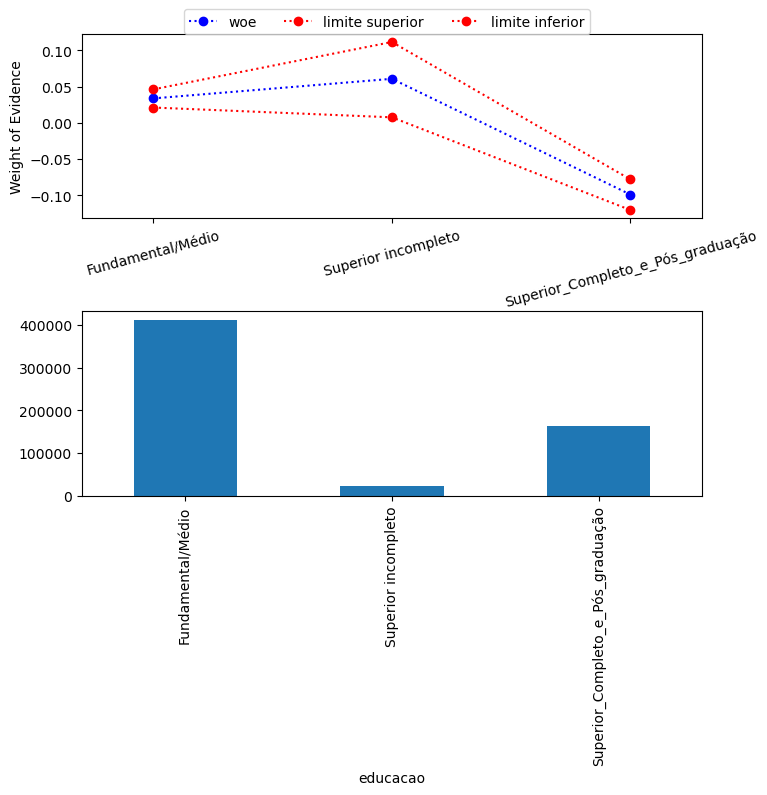

In [29]:
# Acredito que podemos melhorar juntando as classes da variável educacao
df_train.educacao.replace({'Fundamental':'Fundamental/Médio', 
                      'Médio':'Fundamental/Médio', 
                    'Superior completo' : 'Superior_Completo_e_Pós_graduação',
                    'Pós graduação':'Superior_Completo_e_Pós_graduação'
                     }, inplace=True)

biv_discreta('educacao', df_train);
print(df_train.educacao.value_counts())
IV(df_train.educacao, df_train.mau)


Distribuição de tipo_renda:



tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


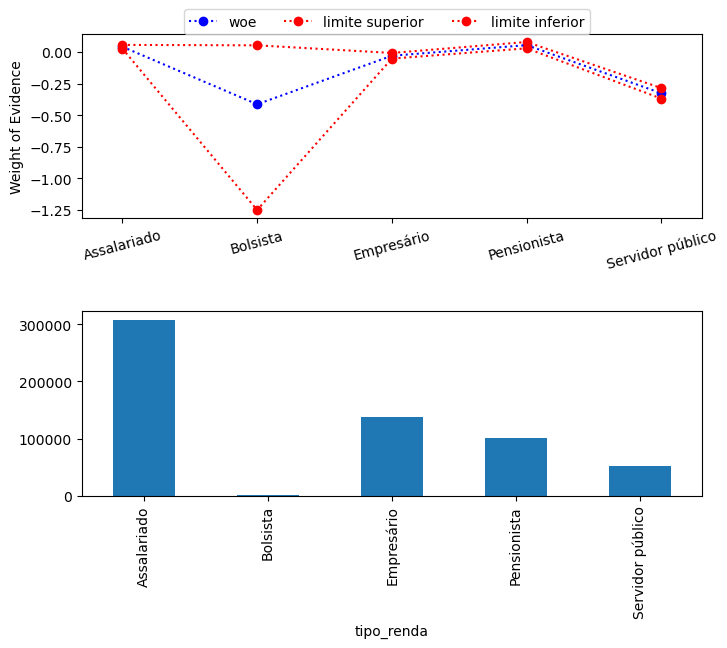

In [30]:
biv_discreta('tipo_renda', df_train);


Distribuição de tipo_renda:



tipo_renda
Assalariado                    308460
Empresário                     138141
Pensionista                    101127
Servidor_público_e_Bolsista     52272
Name: count, dtype: int64

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor_público_e_Bolsista,49930,2342,0.044804,Servidor_público_e_Bolsista,52272,0.000905,0.046578,0.043031,-3.059617,-3.018938,-3.101860,-0.326926,-0.286247,-0.369169


0.00971535486561532

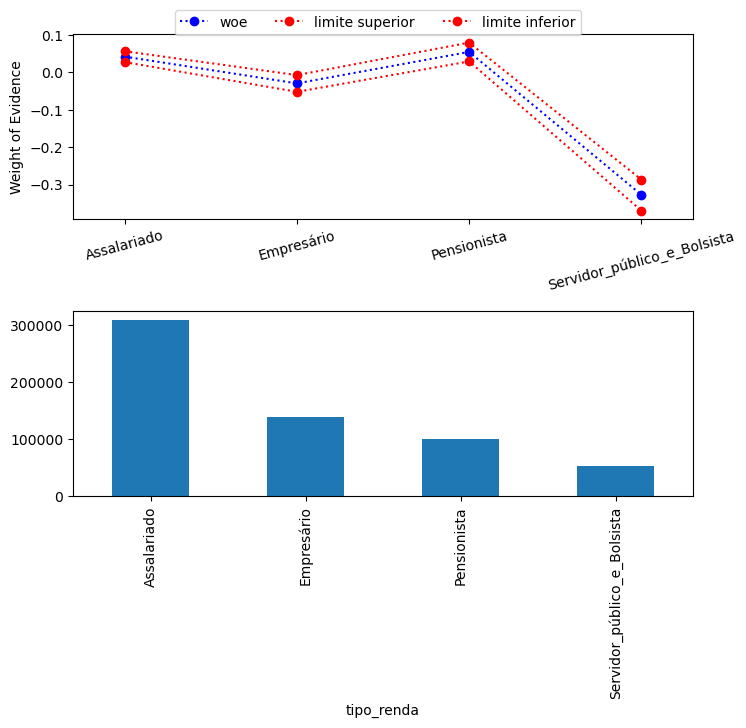

In [31]:
# Acredito que podemos melhorar juntando as classes da variável tipo_renda
df_train.tipo_renda.replace({'Servidor público':'Servidor_público_e_Bolsista', 
                      'Bolsista':'Servidor_público_e_Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df_train);
IV(df_train.tipo_renda, df_train.mau)


Distribuição de tempo_emprego:



tempo_emprego
7.748574     100875
4.216438       1470
4.797260       1072
5.216438       1048
6.934247       1017
              ...  
0.786301         22
5.347945         22
8.887671         22
25.189041        20
38.704110        20
Name: count, Length: 3005, dtype: int64

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 1.0]",48863,5961,0.108730,0.763423,54824,0.001330,0.111336,0.106124,-2.103782,-2.077170,-2.130960,0.628909,0.655521,0.601731
"(1.0, 3.0]",49168,5139,0.094629,1.946029,54307,0.001256,0.097090,0.092167,-2.258384,-2.229979,-2.287460,0.474307,0.502712,0.445231
"(3.0, 4.0]",50061,4479,0.082123,3.318410,54540,0.001176,0.084427,0.079819,-2.413842,-2.383657,-2.444809,0.318849,0.349034,0.287882
"(4.0, 5.0]",50536,4044,0.074093,4.534714,54580,0.001121,0.076290,0.071896,-2.525452,-2.493849,-2.557928,0.207239,0.238842,0.174763
"(5.0, 7.0]",51316,3391,0.061985,5.945289,54707,0.001031,0.064005,0.059964,-2.716878,-2.682643,-2.752171,0.015813,0.050048,-0.019480
"(7.0, 8.0]",128362,8279,0.060589,7.601189,136641,0.000645,0.061854,0.059324,-2.741132,-2.719122,-2.763577,-0.008441,0.013570,-0.030886
"(8.0, 9.0]",25565,1280,0.047681,8.179753,26845,0.001301,0.050230,0.045132,-2.994364,-2.939601,-3.051983,-0.261673,-0.206910,-0.319292
"(9.0, 11.0]",52351,2295,0.041998,9.721809,54646,0.000858,0.043679,0.040316,-3.127238,-3.086217,-3.169861,-0.394547,-0.353526,-0.437170
"(11.0, 16.0]",53206,1267,0.023259,13.291324,54473,0.000646,0.024525,0.021993,-3.737519,-3.683232,-3.794771,-1.004828,-0.950540,-1.062080


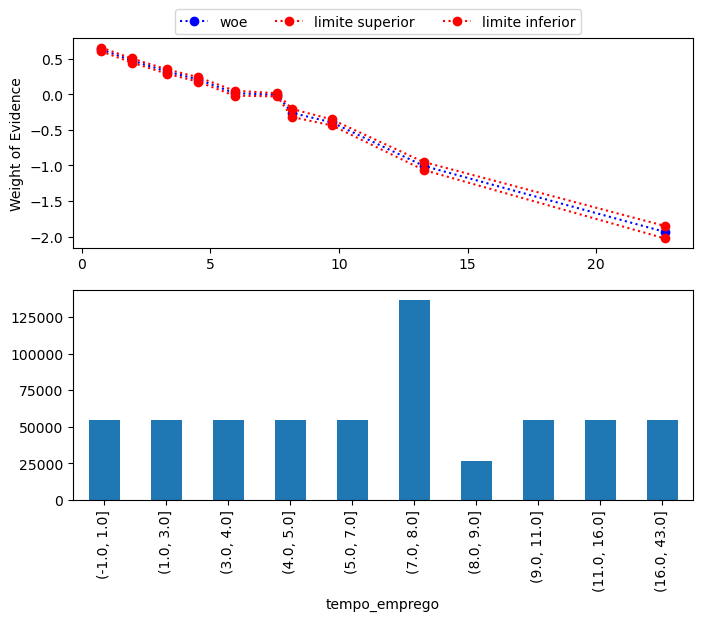

In [32]:
biv_continua('tempo_emprego', 11, df_train);


Distribuição de renda:



renda
1926.67     27
13317.81    26
3564.05     25
3406.49     25
7446.88     24
            ..
8962.34      1
14138.40     1
51272.69     1
29760.89     1
3541.00      1
Name: count, Length: 112472, dtype: int64

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 3905.0]",100204,19799,0.164988,2399.865216,120003,0.001071,0.167088,0.162887,-1.621577,-1.606410,-1.636899,1.111114,1.126281,1.095792
"(3905.0, 7431.0]",111685,8313,0.069276,5558.329421,119998,0.000733,0.070713,0.067839,-2.597862,-2.575790,-2.620361,0.134829,0.156901,0.112330
"(7431.0, 13152.0]",115137,4867,0.040557,10026.531711,120004,0.000569,0.041673,0.039441,-3.163645,-3.135334,-3.192712,-0.430954,-0.402643,-0.460021
"(13152.0, 26667.0]",117316,2684,0.022367,18646.029095,120000,0.000427,0.023203,0.021530,-3.777563,-3.739983,-3.816543,-1.044872,-1.007292,-1.083852
"(26667.0, 4083986.0]",119015,980,0.008167,99487.311946,119995,0.000260,0.008676,0.007658,-4.799452,-4.738452,-4.864347,-2.066761,-2.005761,-2.131656


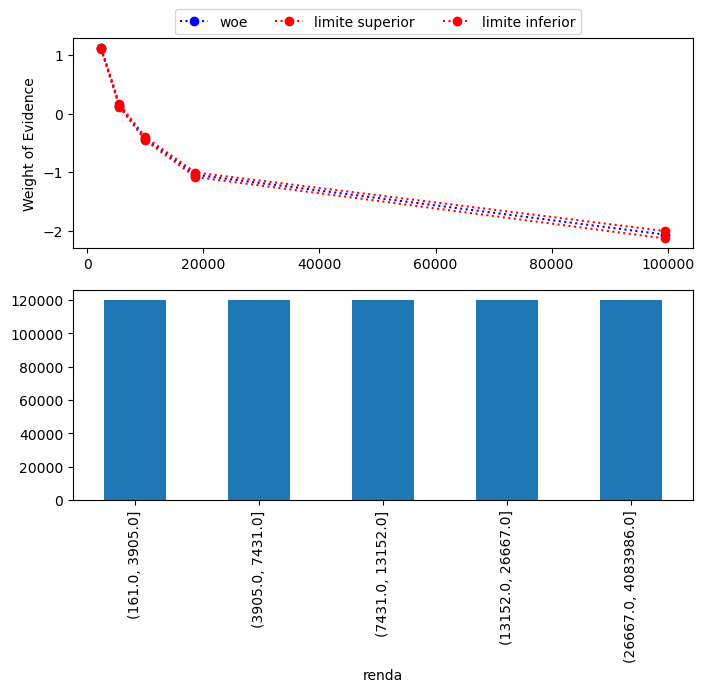

In [33]:
biv_continua('renda', 5, df_train);

In [34]:
' + '.join(df_train.columns)

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [35]:
%%time
formula = '''
        mau ~ sexo + posse_de_veiculo + posse_de_imovel
        + qtd_filhos + tipo_renda + educacao + estado_civil
        + tipo_residencia + idade + tempo_emprego
        + qt_pessoas_residencia + renda
'''
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary().tables[0]

CPU times: total: 16.3 s
Wall time: 11.7 s


Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599977
Model Family:,Binomial,Df Model:,22
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2488e+05
Date:,"Tue, 17 Sep 2024",Deviance:,2.4965e+05
Time:,23:18:10,Pearson chi2:,1.58e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04260
Covariance Type:,nonrobust,,


In [36]:
tabela = pd.read_html(rl.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4232","0,0820","-17,4370","0,0000","-1,5830","-1,2630"
tipo_renda[T.Empresário],"-0,0532","0,0140","-3,7960","0,0000","-0,0810","-0,0260"
tipo_renda[T.Pensionista],"-0,0396","0,0200","-1,9540","0,0510","-0,0790","0,0000"
tipo_renda[T.Servidor_público_e_Bolsista],"-0,0316","0,0230","-1,3610","0,1740","-0,0770","0,0140"
educacao[T.Superior incompleto],"-0,0504","0,0280","-1,7800","0,0750","-0,1060","0,0050"
educacao[T.Superior_Completo_e_Pós_graduação],"-0,0603","0,0130","-4,5520","0,0000","-0,0860","-0,0340"
estado_civil[T.Separado],"0,0463","0,0390","1,2000","0,2300","-0,0290","0,1220"
estado_civil[T.Solteiro],"0,0148","0,0360","0,4170","0,6770","-0,0550","0,0840"
estado_civil[T.União],"0,0475","0,0200","2,3340","0,0200","0,0080","0,0870"
estado_civil[T.Viúvo],"-0,0252","0,0430","-0,5890","0,5560","-0,1090","0,0590"


Analisando o valor de P>|z|, iremos remover as variáveis que tiverem valores superiores a 0,05. Para isso, será necessário transformar algumas variáveis categóricas em dummies, ficando assim o data frame:

In [37]:
df_train_dummies = pd.get_dummies(df_train, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_train_dummies.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,...,educacao_Superior_Completo_e_Pós_graduação,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,0,0,0,43,6.873973,1.0,2515.39,0,1,...,False,False,True,False,False,True,False,False,False,False
1,0,1,1,0,35,4.526027,2.0,3180.19,0,1,...,False,False,False,False,False,True,False,False,False,False


In [38]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + tipo_residencia_Casa
        + sexo + posse_de_veiculo + posse_de_imovel 
        + tempo_emprego + renda  
'''
rl1 = smf.glm(formula, data=df_train_dummies, family=sm.families.Binomial()).fit()

rl1.summary().tables[0]

CPU times: total: 6.72 s
Wall time: 2.75 s


Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599990
Model Family:,Binomial,Df Model:,9
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2489e+05
Date:,"Tue, 17 Sep 2024",Deviance:,2.4967e+05
Time:,23:18:13,Pearson chi2:,1.58e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04257
Covariance Type:,nonrobust,,


In [39]:
tabela = pd.read_html(rl1.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4758","0,0200","-72,7470","0,0000","-1,5160","-1,4360"
tipo_renda_Empresário[T.True],"-0,0435","0,0130","-3,2440","0,0010","-0,0700","-0,0170"
educacao_Superior_Completo_e_Pós_graduação[T.True],"-0,0565","0,0130","-4,3950","0,0000","-0,0820","-0,0310"
estado_civil_União[T.True],"0,0466","0,0200","2,3340","0,0200","0,0070","0,0860"
tipo_residencia_Casa[T.True],"-0,0234","0,0180","-1,3140","0,1890","-0,0580","0,0110"
sexo,"-0,1198","0,0130","-9,2900","0,0000","-0,1450","-0,0950"
posse_de_veiculo,"0,0323","0,0120","2,6520","0,0080","0,0080","0,0560"
posse_de_imovel,"-0,0864","0,0120","-7,3890","0,0000","-0,1090","-0,0630"
tempo_emprego,"-0,0250","0,0020","-14,6630","0,0000","-0,0280","-0,0220"
renda,"-0,0001","0,0000","-93,9260","0,0000","-0,0000","-0,0001"


In [40]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + sexo + posse_de_veiculo
        + posse_de_imovel + tempo_emprego + renda  
'''
rl2 = smf.glm(formula, data=df_train_dummies, family=sm.families.Binomial()).fit()

rl2.summary().tables[0]

CPU times: total: 6.22 s
Wall time: 2.55 s


Dep. Variable:,mau,No. Observations:,600000
Model:,GLM,Df Residuals:,599991
Model Family:,Binomial,Df Model:,8
Link Function:,Logit,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-1.2489e+05
Date:,"Tue, 17 Sep 2024",Deviance:,2.4967e+05
Time:,23:18:16,Pearson chi2:,1.58e+16
No. Iterations:,11,Pseudo R-squ. (CS):,0.04257
Covariance Type:,nonrobust,,


In [41]:
tabela = pd.read_html(rl2.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-1,4940","0,0150","-100,5800","0,0000","-1,5230","-1,4650"
tipo_renda_Empresário[T.True],"-0,0437","0,0130","-3,2600","0,0010","-0,0700","-0,0170"
educacao_Superior_Completo_e_Pós_graduação[T.True],"-0,0563","0,0130","-4,3800","0,0000","-0,0810","-0,0310"
estado_civil_União[T.True],"0,0465","0,0200","2,3290","0,0200","0,0070","0,0860"
sexo,"-0,1191","0,0130","-9,2450","0,0000","-0,1440","-0,0940"
posse_de_veiculo,"0,0323","0,0120","2,6500","0,0080","0,0080","0,0560"
posse_de_imovel,"-0,0895","0,0110","-7,8230","0,0000","-0,1120","-0,0670"
tempo_emprego,"-0,0251","0,0020","-14,7890","0,0000","-0,0280","-0,0220"
renda,"-0,0001","0,0000","-93,9200","0,0000","-0,0000","-0,0001"


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [42]:
# Base de treino
df_train_dummies['score'] = rl2.predict(df_train_dummies)
acuracia_train = metrics.accuracy_score(df_train_dummies.mau, df_train_dummies.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_train_dummies.mau, df_train_dummies.score)
auc_train = metrics.auc(fpr, tpr)
gini_train = 2* auc_train - 1
ks_train = ks_2samp(df_train_dummies.loc[df_train_dummies.mau == 1, 'score'],
              df_train_dummies.loc[df_train_dummies.mau != 1, 'score']).statistic
print(f'BASE DE TREINO\nAcurácia: {acuracia_train:.2f}\nKS: {ks_train:.2f}\nGini: {gini_train:.2f}\nAUC: {auc_train:.2f}')

BASE DE TREINO
Acurácia: 0.59
KS: 0.39
Gini: 0.53
AUC: 0.77


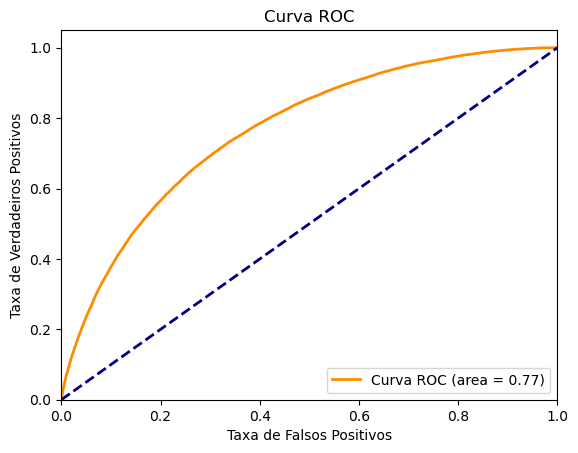

In [43]:
# Gráfico curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_train_dummies['mau'], df_train_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train_dummies['mau'], df_train_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [44]:
# Passando os mesmos tratamentos feitos nas variaveis para a base de teste e out of time
df_test.qtd_filhos.replace({4:3, 5:3, 7:3, 14:3}, inplace=True)
df_test.educacao.replace({'Fundamental':'Fundamental/Médio', 
                      'Médio':'Fundamental/Médio', 
                    'Superior completo' : 'Superior_Completo_e_Pós_graduação',
                    'Pós graduação':'Superior_Completo_e_Pós_graduação'
                     }, inplace=True)
df_test.tipo_renda.replace({'Servidor público':'Servidor_público_e_Bolsista', 
                      'Bolsista':'Servidor_público_e_Bolsista',
                     }, inplace=True)

df_test_dummies = pd.get_dummies(df_test, columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
                                  drop_first=True)
df_test_dummies.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tipo_renda_Empresário,...,educacao_Superior_Completo_e_Pós_graduação,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
600000,0,1,1,2,38,7.383562,4.0,2969.49,1,False,...,True,False,False,False,False,True,False,False,False,False
600001,0,0,1,0,55,8.471233,2.0,6278.37,0,False,...,False,False,False,False,False,True,False,False,False,False


In [45]:
%%time
formula = '''
        mau ~ tipo_renda_Empresário
        + educacao_Superior_Completo_e_Pós_graduação
        + estado_civil_União + sexo + posse_de_veiculo
        + posse_de_imovel + tempo_emprego + renda  
'''
rl_test = smf.glm(formula, data=df_test_dummies, family=sm.families.Binomial()).fit()

tabela = pd.read_html(rl_test.summary().tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|z|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

CPU times: total: 953 ms
Wall time: 503 ms


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,"-0,6223","0,0210","-30,2840","0,0000","-0,6630","-0,5820"
tipo_renda_Empresário[T.True],"-0,0356","0,0180","-1,9490","0,0510","-0,0710","0,0000"
educacao_Superior_Completo_e_Pós_graduação[T.True],"-0,0594","0,0180","-3,3930","0,0010","-0,0940","-0,0250"
estado_civil_União[T.True],"-0,0040","0,0280","-0,1440","0,8850","-0,0580","0,0500"
sexo,"-0,1277","0,0180","-7,2860","0,0000","-0,1620","-0,0930"
posse_de_veiculo,"0,0095","0,0170","0,5680","0,5700","-0,0230","0,0420"
posse_de_imovel,"-0,1142","0,0160","-7,2480","0,0000","-0,1450","-0,0830"
tempo_emprego,"-0,0303","0,0020","-12,4860","0,0000","-0,0350","-0,0260"
renda,"-0,0002","0,0000","-55,4610","0,0000","-0,0000","-0,0000"


In [46]:
# Base de teste
df_test_dummies['score'] = rl_test.predict(df_test_dummies)
acuracia_test = metrics.accuracy_score(df_test_dummies.mau, df_test_dummies.score>.068)
fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies.mau, df_test_dummies.score)
auc_test = metrics.auc(fpr, tpr)
gini_test = 2* auc_test - 1
ks_test = ks_2samp(df_test_dummies.loc[df_test_dummies.mau == 1, 'score'],
              df_test_dummies.loc[df_test_dummies.mau != 1, 'score']).statistic
print(f'BASE DE TESTE\nAcurácia: {acuracia_test:.2f}\nKS: {ks_test:.2f}\nGini: {gini_test:.2f}\nAUC: {auc_test:.2f}')

BASE DE TESTE
Acurácia: 0.36
KS: 0.34
Gini: 0.47
AUC: 0.73


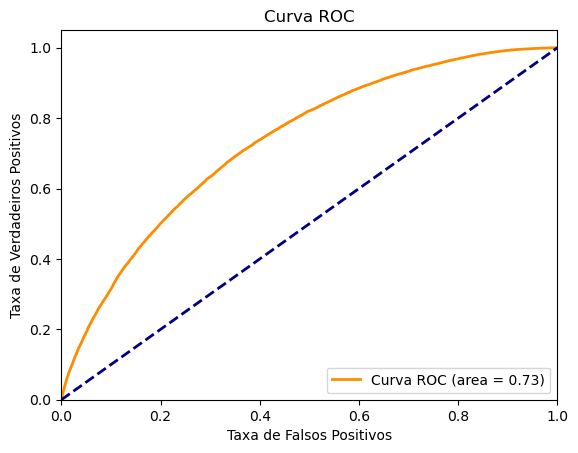

In [47]:
# Gráfico curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies['mau'], df_test_dummies['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test_dummies['mau'], df_test_dummies['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Resultados:

Houve uma grande queda na acurácia entre as bases de treino e teste, enquanto as demais métricas como KS, Gini e AUC tiveram quedas suaves. Confira os resultados abaixo:

| Métricas | Treino | Teste |
|:-|:-|:-|
| Acurácia | 0.59 | 0.36 |
| KS | 0.39 | 0.34 |
| Gini | 0.53 | 0.47 |
| AUC | 0.77 | 0.73 |
